https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data



In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "Stock_Data/Stocks"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1a-I9epOaGdMqEQjvMO-SGs4iDefnoraJ/Stocks


In [2]:
"""LSTM Model"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


import plotly.graph_objects as go

import xgboost as xgb

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

class PriceClassifier():

  stock: str
  stock_history_df: pd.DataFrame
  model: Sequential

  def __init__(self, stock: str):
    self.stock = stock
    self.stock_history_df = self._get_stock_history_df()
    self.train_data, self.test_data, self.val_data = self._create_train_and_test_set()
    self.X_train, self.y_train, self.X_val, self.y_val, self.X_test = self._preprocess()

  def _get_stock_history_df(self):
    stock_country = "us"
    stock_history_path = f"{self.stock}.{stock_country}.txt"
    return pd.read_csv(stock_history_path)

  def plot_daily_close(self):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y='Close', data=self.stock_history_df)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.title('AMTD daily close price 2010-2017')
    plt.show()

  def _create_train_and_test_set(self):
    train_size = 0.8
    test_size = 0.1
    validation_size = 0.1
    dataset = self.stock_history_df

    train_end = int(len(dataset) * train_size)
    test_end = train_end + int(len(dataset) * test_size)

    train_data = dataset.iloc[:train_end]
    test_data = dataset.iloc[train_end:test_end]
    validation_data = dataset.iloc[test_end:]
    return train_data, test_data, validation_data

  def plot_train_test_val(self):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=self.train_data['Date'], y=self.train_data['Close'], mode='lines', name='Train data'))
    fig.add_trace(go.Scatter(x=self.test_data['Date'], y=self.test_data['Close'], mode='lines', name='Test data'))
    fig.add_trace(go.Scatter(x=self.val_data['Date'], y=self.val_data['Close'], mode='lines', name='Validation data'))


    fig.update_layout(
        title=f'{self.stock.upper()} daily close price 2010-2017',
        xaxis_title='Date',
        yaxis_title='Close price',
    )

    fig.show()

  def _preprocess(self):
    X_train = self.train_data.drop(columns=['Close', 'Date'])
    y_train = self.train_data['Close']
    X_validation = self.val_data.drop(columns=['Close', 'Date'])
    y_validation = self.val_data['Close']
    X_test = self.test_data.drop(columns=['Close', 'Date'])
    return X_train, y_train, X_validation, y_validation, X_test

  def train(self, model=None, optimizer=None, epochs=50, batch_size=32, loss="mean_squared_error"):
    if not model:
      model = Sequential()
      model.add(LSTM(units=50,return_sequences=True,input_shape=(self.X_train.shape[1], 1)))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50))
      model.add(Dropout(0.2))
      model.add(Dense(units=1))

    if not optimizer:
      optimizer = Adam()
    model.compile(optimizer=optimizer,loss=loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(self.X_train,self.y_train,epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(self.X_val, self.y_val),
                        callbacks=[early_stopping])
    self.model = model

  def predict(self):
    test_preds = self.model.predict(self.X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(self.test_data['Date']), self.test_data['Close'], label='Actual')
    plt.plot(pd.to_datetime(self.test_data['Date']), test_preds, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs. Test {self.stock.upper()} daily close prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [3]:
## Example of how to load a single stock into a Pandas Dataframe.
amtd_model = PriceClassifier("amtd")
amtd_model.stock_history_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,7.1722,7.3563,7.1457,7.2511,5375043,0
1,2005-02-28,7.2949,7.3388,7.1194,7.1808,4602417,0
2,2005-03-01,7.1808,7.2597,7.1194,7.1808,5648916,0
3,2005-03-02,7.1457,7.5493,7.0931,7.4439,10262412,0
4,2005-03-03,7.4879,7.6632,7.2949,7.3299,5287947,0


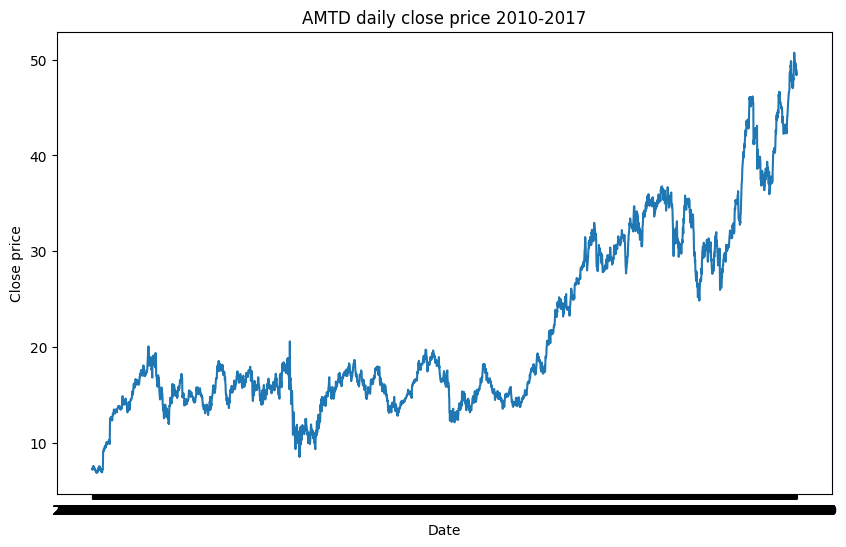

In [4]:
amtd_model.plot_daily_close()

In [5]:
amtd_model.plot_train_test_val()

In [6]:
amtd_model.train()

Epoch 1/50
80/80 [==============================] - 16s 33ms/step - loss: 159.2254 - val_loss: 808.6015
Epoch 2/50
80/80 [==============================] - 1s 12ms/step - loss: 54.6095 - val_loss: 653.8181
Epoch 3/50
80/80 [==============================] - 1s 11ms/step - loss: 41.9325 - val_loss: 579.7628
Epoch 4/50
80/80 [==============================] - 1s 9ms/step - loss: 39.6001 - val_loss: 551.0142
Epoch 5/50
80/80 [==============================] - 1s 8ms/step - loss: 39.4964 - val_loss: 540.2210
Epoch 6/50
80/80 [==============================] - 1s 8ms/step - loss: 39.9112 - val_loss: 540.5161
Epoch 7/50
80/80 [==============================] - 1s 9ms/step - loss: 39.8275 - val_loss: 537.7988
Epoch 8/50
80/80 [==============================] - 1s 9ms/step - loss: 39.7941 - val_loss: 537.4194
Epoch 9/50
80/80 [==============================] - 1s 9ms/step - loss: 39.4957 - val_loss: 538.4893
Epoch 10/50
80/80 [==============================] - 1s 9ms/step - loss: 39.5089 - val

10/10 [==============================] - 1s 4ms/step


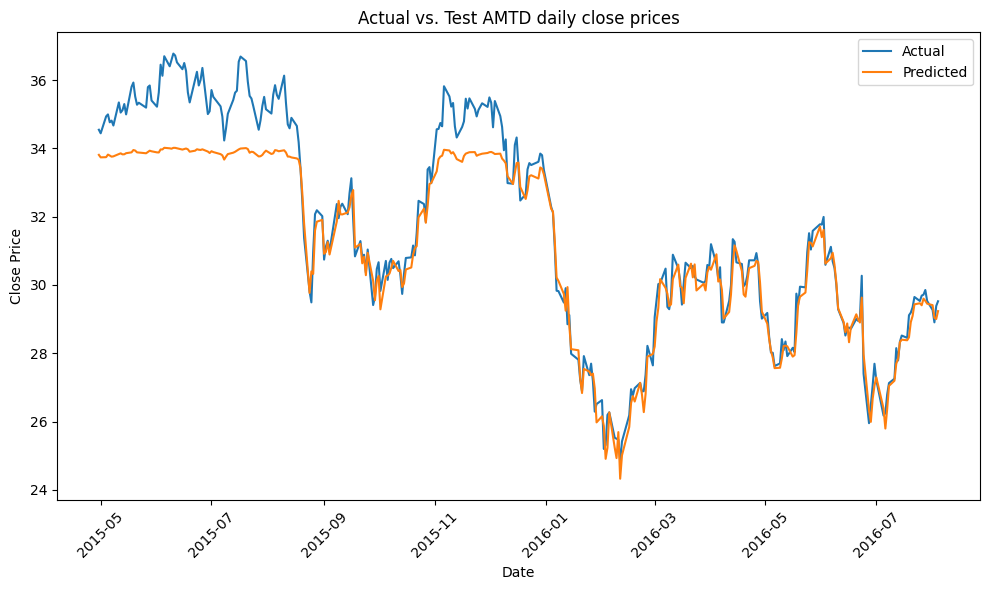

In [7]:
amtd_model.predict()

In [8]:
from keras.optimizers import Adam
from keras import regularizers
msft_model = PriceClassifier("msft")
model = Sequential()
model.add(LSTM(units=50,input_shape=(msft_model.X_train.shape[1], 1), dropout=.2, recurrent_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3), return_sequences=True))
model.add(LSTM(units=50,input_shape=(msft_model.X_train.shape[1], 1), dropout=.2, recurrent_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3)))

model.add(Dense(units=1))
optimizer = Adam()
msft_model.train(model=model, optimizer=optimizer, epochs=50, loss="mean_squared_error")

Epoch 1/50
200/200 [==============================] - 11s 17ms/step - loss: 106.3814 - val_loss: 1511.9960
Epoch 2/50
200/200 [==============================] - 2s 12ms/step - loss: 24.9640 - val_loss: 1175.4668
Epoch 3/50
200/200 [==============================] - 3s 14ms/step - loss: 12.5501 - val_loss: 1012.7859
Epoch 4/50
200/200 [==============================] - 2s 11ms/step - loss: 9.2141 - val_loss: 898.0050
Epoch 5/50
200/200 [==============================] - 2s 10ms/step - loss: 6.7239 - val_loss: 806.7070
Epoch 6/50
200/200 [==============================] - 2s 10ms/step - loss: 4.7735 - val_loss: 730.6827
Epoch 7/50
200/200 [==============================] - 2s 10ms/step - loss: 4.0107 - val_loss: 670.5064
Epoch 8/50
200/200 [==============================] - 2s 12ms/step - loss: 3.9065 - val_loss: 622.9048
Epoch 9/50
200/200 [==============================] - 3s 15ms/step - loss: 3.7802 - val_loss: 583.9410
Epoch 10/50
200/200 [==============================] - 2s 11ms/st

25/25 [==============================] - 1s 3ms/step


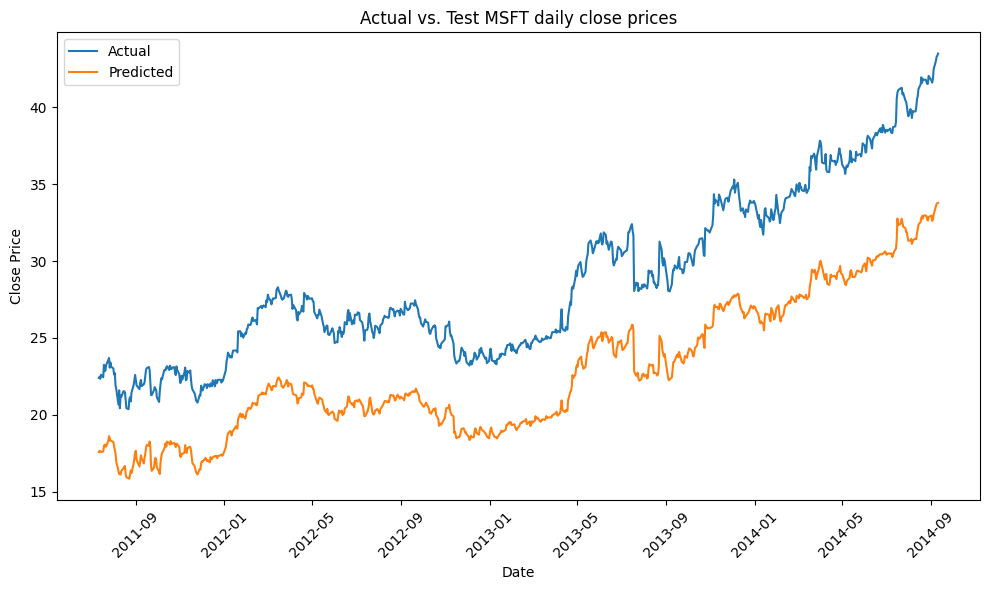

In [9]:
msft_model.predict()

--------------------------------------------------------------------------------


Correlation Stuff

In [ ]:
import pandas as pd
import glob

# List all CSV files in the current directory
csv_files = ['aa.us.txt', 'abb.us.txt', 'aau.us.txt']

# Create an empty DataFrame to store merged data
merged_data = None

# Read and merge data from all CSV files
for file in csv_files:
    stock_data = pd.read_csv(file)
    if merged_data is None:
      merged_data = stock_data
    else:
      merged_data = pd.merge(merged_data, stock_data, on='Date', how='outer')

merged_data.dropna(inplace=True)
print(merged_data.head())

# Calculate correlation for each pair of stocks
correlation_matrix = merged_data.corr()

print(correlation_matrix)
